In [1]:
!pip install -U -q lightautoml

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
datasets 2.19.1 requires aiohttp, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.1 which is incompatible.
cudf 24.4.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which is incompatible.
cudf 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
dask-cudf 24.4.1 requires pandas<2.2.2dev0,>=2.0, bu

# Configs and Imports

In [2]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import torch
import glob

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

In [3]:
TARGET_NAME = 'Target'
TEST_SIZE = 0.1
N_THREADS = 4
TIMEOUT = 3600 * 8
N_FOLDS = 5
SEED = 27

In [4]:
np.random.seed(SEED)
torch.set_num_threads(N_THREADS)

# Loadingthe Datasets

In [5]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

# Training

In [6]:
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

histories = {}
oof_preds = np.zeros((len(train), train[TARGET_NAME].nunique()))
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train.drop(columns=TARGET_NAME), train[TARGET_NAME])):
    _train, _val = train.iloc[train_idx], train.iloc[val_idx]    

    automl = TabularAutoML(
        task=Task(name='multiclass'),
        timeout=TIMEOUT,
        cpu_limit=N_THREADS,
        reader_params={
            'n_jobs': N_THREADS,
            'cv':  N_FOLDS,
            'random_state': SEED
        },
        tuning_params = {'max_tuning_time': 1800},
    )

    _ = automl.fit_predict(
        _train,
        roles={'target': TARGET_NAME},
        verbose=1
    )
    
    class_mapping = automl.reader.class_mapping
    class_mapping = {v: k for k, v in class_mapping.items()}
    reverse_class_mapping = {v: k for k, v in class_mapping.items()}
    
    pred_probs = automl.predict(_val).data
    preds = pred_probs.argmax(axis=1)
    oof_preds[val_idx] = pred_probs
    
    fold_accuracy = accuracy_score(_val[TARGET_NAME].map(reverse_class_mapping), preds)
    
    test_pred_probs = automl.predict(test).data
    
    test_preds = test_pred_probs.argmax(axis=1)
    test_preds = pd.DataFrame({TARGET_NAME: test_preds}, index=test.index)
    test_preds[TARGET_NAME] = test_preds[TARGET_NAME].map(class_mapping)
    test_preds.to_csv(f'fold_{fold_idx}_test_preds_acc-{fold_accuracy:.6f}.csv')
    
    test_pred_probs = pd.DataFrame(test_pred_probs, index=test.index)
    test_pred_probs.columns = class_mapping.values()
    test_pred_probs.to_csv(f'fold_{fold_idx}_test_pred_probs_acc-{fold_accuracy:.6f}.csv')
    
    histories[f'Fold {fold_idx}'] = {}
    histories[f'Fold {fold_idx}']['y'] = _val[TARGET_NAME].values
    histories[f'Fold {fold_idx}']['pred_probs'] = pred_probs
    histories[f'Fold {fold_idx}']['preds'] = preds
    histories[f'Fold {fold_idx}']['accuracy'] = fold_accuracy
    histories[f'Fold {fold_idx}']['auc'] = roc_auc_score(_val[TARGET_NAME].map(reverse_class_mapping), pred_probs, multi_class='ovo')
    
    
    print(f'Fold {fold_idx} - Accuracy: {fold_accuracy}')
    
    del automl

[12:08:26] Stdout logging level is INFO.
[12:08:26] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[12:08:26] Task: multiclass

[12:08:26] Start automl preset with listed constraints:
[12:08:26] - time: 28800.00 seconds
[12:08:26] - CPU: 4 cores
[12:08:26] - memory: 16 GB

[12:08:26] Train data shape: (61214, 37)

[12:08:36] Layer 1 train process start. Time left 28789.97 secs
[12:08:40] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:09:23] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.44558852804228793
[12:09:23] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:09:23] Time left 28742.80 secs

[12:09:37] Selector_LightGBM fitting and predicting completed
[12:09:41] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:12:12] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.43724358820188525
[12:12:12] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:12:12] Start hyperparameters optimiz

In [7]:
with open('laml_oof_preds.pkl', 'wb') as f:
    pickle.dump(oof_preds, f)

In [8]:
histories['All'] = {}
histories['All']['accuracy'] = accuracy_score(train[TARGET_NAME].map(reverse_class_mapping), oof_preds.argmax(axis=1))
histories['All']['auc'] = roc_auc_score(train[TARGET_NAME].map(reverse_class_mapping), oof_preds, multi_class='ovo')
histories['All']['pred_probs'] = oof_preds
histories['All']['preds'] = oof_preds.argmax(axis=1)
histories['All']['y'] = train[TARGET_NAME].values

# Results

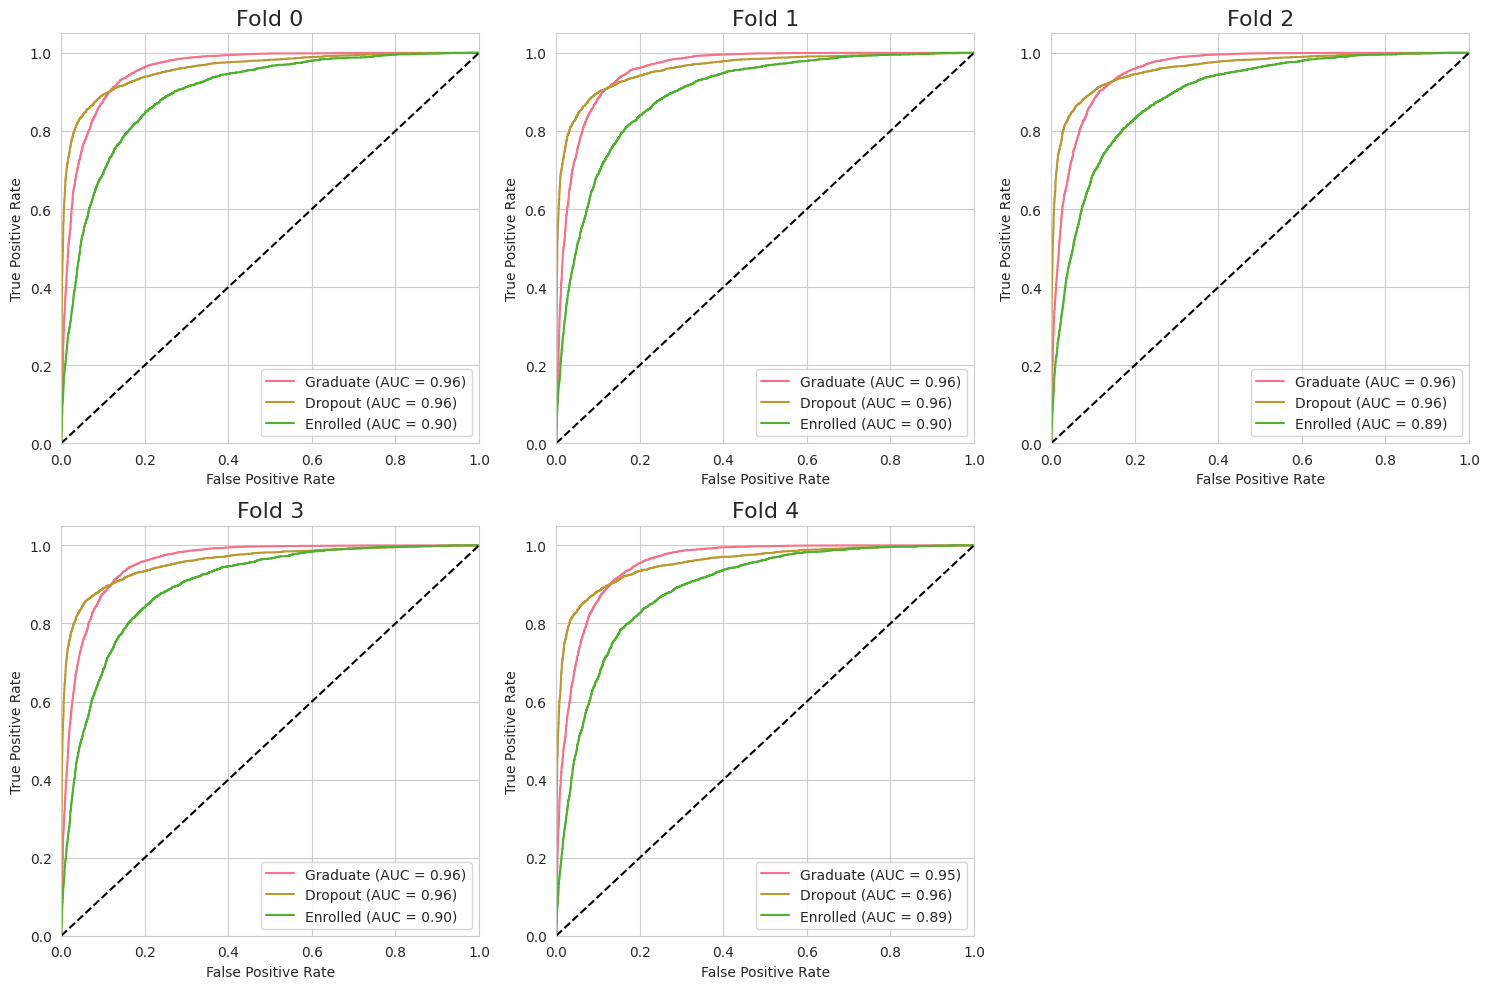

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    pred_probs = histories[f'Fold {fold_idx}']['pred_probs']
    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']
    
    y = np.array([reverse_class_mapping[p] for p in y])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(pred_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y == i, pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(pred_probs.shape[1]):
        ax.plot(fpr[i], tpr[i], label=f'{class_mapping[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

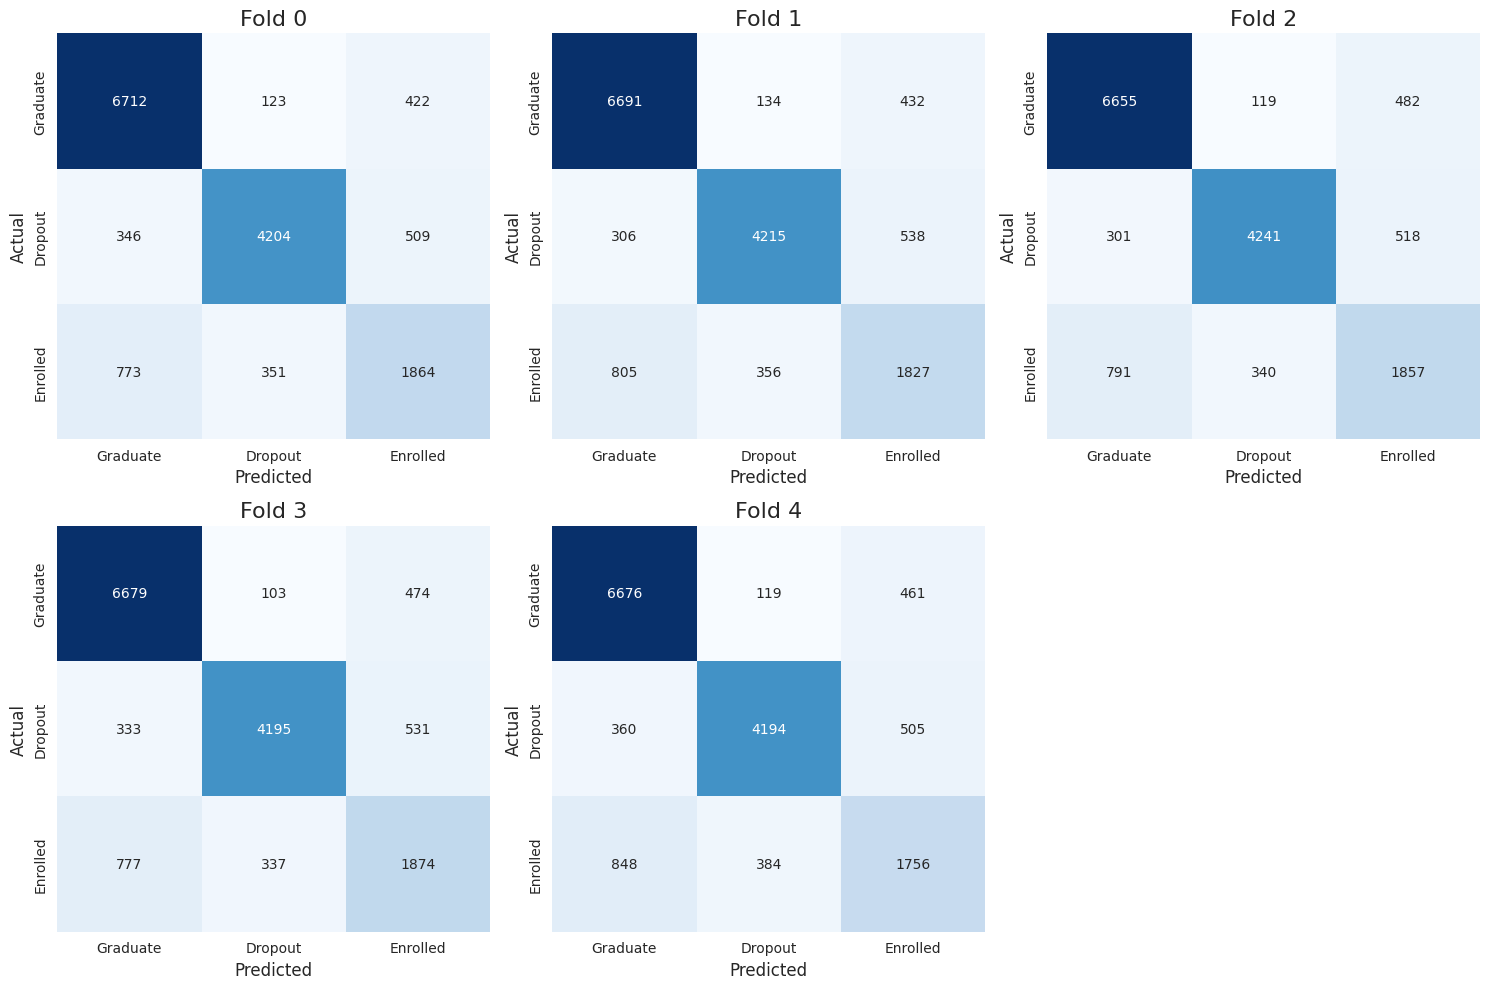

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    y = np.array([reverse_class_mapping[p] for p in y])

    cm = confusion_matrix(y, preds)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        ax=ax,
        cmap='Blues',
        cbar=False,
        xticklabels=class_mapping.values(),
        yticklabels=class_mapping.values()
    )

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Fold {fold_idx}', fontsize=16)

plt.tight_layout()
plt.show()

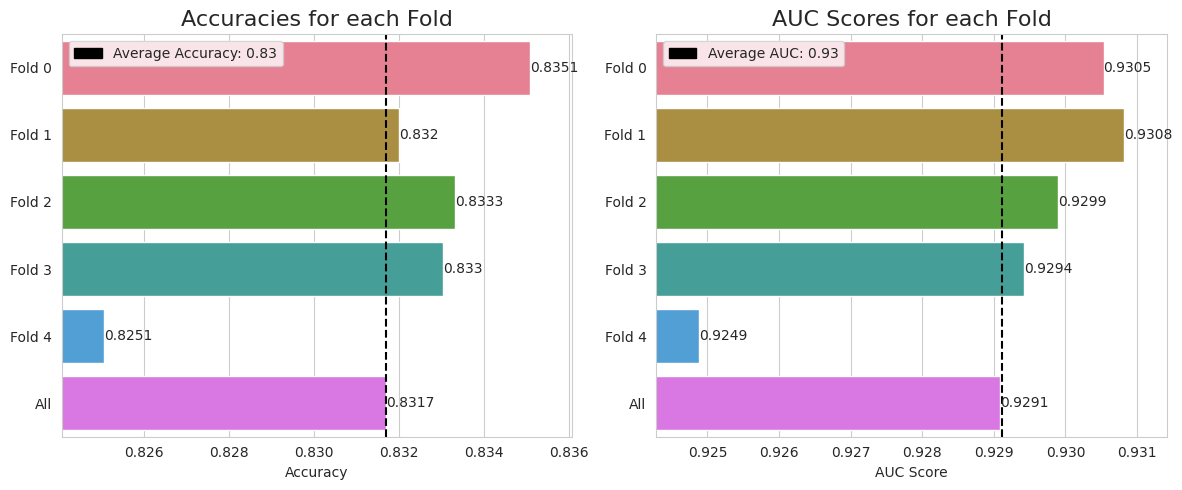

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

accuracies = [histories[f'Fold {i}']['accuracy'] for i in range(N_FOLDS)]
mean_accuracy = np.mean(accuracies)
accuracies = accuracies + [histories['All']['accuracy']]

min_acc = min(accuracies)
max_acc = max(accuracies)
acc_padding = (max_acc - min_acc) * 0.1
acc_lower_limit = min_acc - acc_padding
acc_upper_limit = max_acc + acc_padding

acc_barplot = sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=accuracies, ax=axs[0], palette='husl', orient='h')
axs[0].axvline(mean_accuracy, color='black', linestyle='--')
axs[0].set_xlim(left=acc_lower_limit, right=acc_upper_limit)
axs[0].set_xlabel('Accuracy')
axs[0].set_title('Accuracies for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average Accuracy: {mean_accuracy:.2f}')
axs[0].legend(handles=[blue_patch], loc='best')
for i, score in enumerate(accuracies):
    acc_barplot.text(score, i, round(score, 4), va = 'center')


auc_scores = [histories[f'Fold {i}']['auc'] for i in range(N_FOLDS)]
mean_auc = np.mean(auc_scores)
auc_scores = auc_scores + [histories['All']['auc']]

min_auc = min(auc_scores)
max_auc = max(auc_scores)
auc_padding = (max_auc - min_auc) * 0.1
auc_lower_limit = min_auc - auc_padding
auc_upper_limit = max_auc + auc_padding

auc_barplot = sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=auc_scores, ax=axs[1], palette='husl', orient='h')
axs[1].axvline(mean_auc, color='black', linestyle='--')
axs[1].set_xlim(left=auc_lower_limit, right=auc_upper_limit)
axs[1].set_xlabel('AUC Score')
axs[1].set_title('AUC Scores for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average AUC: {mean_auc:.2f}')
axs[1].legend(handles=[blue_patch], loc='best')
for i, score in enumerate(auc_scores):
    auc_barplot.text(score, i, round(score, 4), va = 'center')

plt.tight_layout()
plt.show()

# Post-Processing and Inference

In [12]:
files = glob.glob('fold_*_test_pred_probs_*.csv')
submissions = [pd.read_csv(f, index_col='id') for f in files]

submission = pd.concat(submissions, axis=1)
submission = submission.groupby(level=0, axis=1).mean()

submission['Target'] = submission.idxmax(axis=1)
submission['id'] = submission.index
submission = submission[['id', 'Target']]

submission.to_csv(f'laml_acc-{mean_accuracy:.6f}_auc-{mean_auc:.6f}.csv', index=False)
submission.head()

,id,Target
id,,
76518,76518,Dropout
76519,76519,Graduate
76520,76520,Graduate
76521,76521,Graduate
76522,76522,Enrolled
